<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_Fundamental.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Stock trading with fundamentals

* This notebook is based on the tutorial: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530

* This project is a result of the almuni-mentored research project at Columbia University, Application of Reinforcement Learning to Finance.
* For detailed explanation, please check out the Medium article: https://medium.com/@mariko.sawada1/automated-stock-trading-with-deep-reinforcement-learning-and-financial-data-a63286ccbe2b



# Content

* [1. Task Discription](#1)
* [2. Install Python packages](#2)
    * [2.1. Install Packages](#2.1)
    * [2.2. A List of Python Packages](#2.2)
    * [2.3. Import Packages](#2.3)
    * [2.4. Create Folders](#2.4)
* [3. Download Data](#3)
* [4. Preprocess fundamental Data](#4)
    * [4.1 Import financial data](#4.1)
    * [4.2 Specify items needed to calculate financial ratios](#4.2)
    * [4.3 Calculate financial ratios](#4.3)
    * [4.4 Deal with NAs and infinite values](#4.4)
    * [4.5 Merge stock price data and ratios into one dataframe](#4.5)
    * [4.6 Calculate market valuation ratios using daily stock price data](#4.6)
* [5. Build Environment](#5)
    * [5.1. Training & Trade Data Split](#5.1)
    * [5.2. User-defined Environment](#5.2)
    * [5.3. Initialize Environment](#5.3)
* [6. Train DRL Agents](#6)  
* [7. Backtesting Performance](#7)  
    * [7.1. BackTestStats](#7.1)
    * [7.2. BackTestPlot](#7.2)

<a name='1'></a>
# Part 1. Task Description

<a name='2'></a>
# Part 2. Load Python Packages

<a name='2.1'></a>
## 2.1. Install all the packages through FinRL library


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd '/content/drive/MyDrive/Colab Notebooks/DRL/App/DRL/FinRL'
!ls

/content/drive/MyDrive/Colab Notebooks/DRL/App/DRL/FinRL
 anytrade
 binance-22-25
 condacolab_install.log
 datasets
 FinRL
 FinRl_Basic.ipynb
 FinRL_HyperparameterTuning_Optuna.ipynb
'FinRL_PortfolioAllocation_Explainable_DRL (1).ipynb'
 FinRL_PortfolioAllocation_Explainable_DRL.ipynb
 FinRL_PortfolioAllocation_NeurIPS_2020.ipynb
 MultiCrypto_Trading.ipynb
 result.csv
 results
 Stock_NeurIPS2018_SB3.ipynb
 tensorboard_log
 trained_models
 vix_daily.csv


In [9]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install 'shimmy>=2.0'

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-8bs5vjxq
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-8bs5vjxq
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit dcf6bde8d64e1a747673d24dde30dce195bc3cf1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-sx60ep9w/elegantrl_8694c936815341bc9d75a638ad471029
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-sx60ep9w/elegantrl_8694c936815341bc9d75a638ad471029
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 7c64395ff4c2b53892fe6f9eaa3b58947136ffc1
  Preparing metadata (setup.py) ... done
  Using cached alpaca_py-0.37.0-py3-none-any.whl.met

In [10]:
# !sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

# # ## install required packages

# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# ## install finrl library
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [11]:
# ## install finrl library
# !pip install plotly==4.4.1
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install PyPortfolioOpt


<a name='2.2'></a>
## 2.2. A List of Python Packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* pyfolio

<a name='2.3'></a>
## 2.3. Import Packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from pprint import pprint
from stable_baselines3.common.logger import configure
import sys
sys.path.append("../FinRL")

import itertools

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

# from finrl.config_tickers import DOW_30_TICKER

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

<a id='1.4'></a>
## 2.4. Create Folders

In [13]:
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a name='3'></a>
# Part 3. Download Stock Data

In [14]:
import os

# Directory containing your feather files
data_dir = r"binance-22-25"  # <-- change this

# List of assets you want to include
assets = ['BTC_USDT', 'ETH_USDT', 'SOL_USDT']  # <-- customize this

# Desired timeframe(s)
tf = '1d'
# Container for all loaded DataFrames
df_list = []

for asset in assets:
      file_path = os.path.join(data_dir, f"{asset}-{tf}.feather")
      if os.path.exists(file_path):
          # Load feather file
          df = pd.read_feather(file_path)

          # Add ticker_name and timeframe info
          df["tic"] = asset

          # Keep only consistent OHCLV columns + metadata
          cols = ["date", "open", "high", "low", "close", "volume", "tic"]
          df = df[[col for col in cols if col in df.columns]]
          df_list.append(df)
      else:
          print(f"⚠️ File not found: {file_path}")
# Combine all into a single composite DataFrame
if df_list:
    df = pd.concat(df_list, ignore_index=True)
    df = df.sort_values(by=["date", "tic"]).reset_index(drop=True)
else:
    df = pd.DataFrame()
df["date"] = df["date"].dt.strftime('%d-%m-%Y')

# --- Final check ---
print("✅ Composite DataFrame created!")
print(df.head(10))
print(df.tail(10))
print(f"\nTotal records: {len(df):,}")


✅ Composite DataFrame created!
         date        open      high         low       close        volume  \
0  01-01-2021  28923.6300  29600.00  28624.5700  29331.6900  5.418293e+04   
1  01-01-2021    736.4200    749.00    714.2900    728.9100  6.751141e+05   
2  01-01-2021      1.5088      1.86      1.4990      1.8421  4.421991e+06   
3  02-01-2021  29331.7000  33300.00  28946.5300  32178.3300  1.299939e+05   
4  02-01-2021    728.9100    787.69    714.9100    774.5600  1.352619e+06   
5  02-01-2021      1.8421      2.00      1.7116      1.7999  5.253820e+06   
6  03-01-2021  32176.4500  34778.11  31962.9900  33000.0500  1.209576e+05   
7  03-01-2021    774.4400   1011.07    768.7100    978.2800  2.813604e+06   
8  03-01-2021      1.7998      2.38      1.7973      2.1779  8.318341e+06   
9  04-01-2021  33000.0500  33600.00  28130.0000  31988.7100  1.408999e+05   

        tic  
0  BTC_USDT  
1  ETH_USDT  
2  SOL_USDT  
3  BTC_USDT  
4  ETH_USDT  
5  SOL_USDT  
6  BTC_USDT  
7  ETH_US

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
df.sort_values(['date','tic']).head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,date,open,high,low,close,volume,tic
0,01-01-2021,28923.6300,29600.00,28624.570,29331.6900,5.418293e+04,BTC_USDT
1,01-01-2021,736.4200,749.00,714.290,728.9100,6.751141e+05,ETH_USDT
2,01-01-2021,1.5088,1.86,1.499,1.8421,4.421991e+06,SOL_USDT
1095,01-01-2022,46216.9300,47954.63,46208.370,47722.6500,1.960446e+04,BTC_USDT
1096,01-01-2022,3676.2200,3776.45,3673.460,3765.5400,1.541439e+05,ETH_USDT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
TRAIN_START_DATE = df['date'].iloc[0]
TRAIN_END_DATE = '2023-03-11'
TRADE_START_DATE = '2023-03-12'
TRADE_END_DATE = df['date'].iloc[-1]

In [17]:
df.shape

(2997, 7)

In [18]:
df

,date,open,high,low,close,volume,tic
0,01-01-2021,28923.6300,29600.00,28624.570,29331.6900,5.418293e+04,BTC_USDT
1,01-01-2021,736.4200,749.00,714.290,728.9100,6.751141e+05,ETH_USDT
2,01-01-2021,1.5088,1.86,1.499,1.8421,4.421991e+06,SOL_USDT
3,02-01-2021,29331.7000,33300.00,28946.530,32178.3300,1.299939e+05,BTC_USDT
4,02-01-2021,728.9100,787.69,714.910,774.5600,1.352619e+06,ETH_USDT
...,...,...,...,...,...,...,...
2992,25-09-2023,1580.7100,1597.50,1563.010,1588.3300,1.767069e+05,ETH_USDT
2993,25-09-2023,19.3600,19.74,19.070,19.3900,1.702995e+06,SOL_USDT
2994,26-09-2023,26304.8000,26397.46,26088.340,26221.6700,1.849535e+04,BTC_USDT
2995,26-09-2023,1588.3400,1599.78,1580.050,1594.0100,1.255830e+05,ETH_USDT


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [19]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
# DEBUG: Resolved miss-align error
# --- Ensure date column is datetime ---
# Handles cases like '13-01-2021' or '2021-01-13'
processed["date"] = pd.to_datetime(processed["date"], errors="coerce", dayfirst=True).dt.normalize()

# Drop rows with invalid (NaT) dates if any
processed = processed.dropna(subset=["date"])

# --- Build all combinations of dates and tickers ---
list_ticker = processed["tic"].unique().tolist()
list_date = pd.date_range(processed["date"].min(), processed["date"].max(), freq='D')

# --- Create full date-ticker frame ---
combination = list(itertools.product(list_date, list_ticker))
processed_full = pd.DataFrame(combination, columns=["date", "tic"])

# --- Merge safely ---
processed_full = processed_full.merge(processed, on=["date", "tic"], how="left")

# --- Sort and fill missing ---
processed_full = processed_full.sort_values(["date", "tic"]).reset_index(drop=True)
processed_full = processed_full.fillna(0)

print("✅ Processed full dataframe created successfully!")
print(processed_full.head(10))


✅ Processed full dataframe created successfully!
        date       tic        open      high         low       close  \
0 2021-01-01  BTC_USDT  28923.6300  29600.00  28624.5700  29331.6900   
1 2021-01-01  ETH_USDT    736.4200    749.00    714.2900    728.9100   
2 2021-01-01  SOL_USDT      1.5088      1.86      1.4990      1.8421   
3 2021-01-02  BTC_USDT  29331.7000  33300.00  28946.5300  32178.3300   
4 2021-01-02  ETH_USDT    728.9100    787.69    714.9100    774.5600   
5 2021-01-02  SOL_USDT      1.8421      2.00      1.7116      1.7999   
6 2021-01-03  BTC_USDT  32176.4500  34778.11  31962.9900  33000.0500   
7 2021-01-03  ETH_USDT    774.4400   1011.07    768.7100    978.2800   
8 2021-01-03  SOL_USDT      1.7998      2.38      1.7973      2.1779   
9 2021-01-04  BTC_USDT  33000.0500  33600.00  28130.0000  31988.7100   

         volume        macd       boll_ub       boll_lb      rsi_30  \
0  5.418293e+04    0.000000  64535.915057  12518.424943  100.000000   
1  6.751141e+05 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<a name='5'></a>
# Part 5. A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

<a name='5.1'></a>
## 5.1 Data Split
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [21]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

2397
819


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [22]:
train_data.head()

,date,tic,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2021-01-01,BTC_USDT,28923.6300,29600.00,28624.570,29331.6900,5.418293e+04,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,29331.690000,29331.690000
0,2021-01-01,ETH_USDT,736.4200,749.00,714.290,728.9100,6.751141e+05,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,728.910000,728.910000
0,2021-01-01,SOL_USDT,1.5088,1.86,1.499,1.8421,4.421991e+06,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,1.842100,1.842100
1,2021-01-02,BTC_USDT,29331.7000,33300.00,28946.530,32178.3300,1.299939e+05,-301.789007,57869.663951,6881.239049,49.913959,-22.056404,3.589193,35243.295333,34838.127059
1,2021-01-02,ETH_USDT,728.9100,787.69,714.910,774.5600,1.352619e+06,-23.208266,4293.467975,55.606025,48.228902,-129.005839,1.956872,2238.156333,2182.754412


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
trade_data.head()

,date,tic,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2021-01-01,BTC_USDT,28923.6300,29600.00,28624.570,29331.6900,5.418293e+04,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,29331.690000,29331.690000
0,2021-01-01,ETH_USDT,736.4200,749.00,714.290,728.9100,6.751141e+05,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,728.910000,728.910000
0,2021-01-01,SOL_USDT,1.5088,1.86,1.499,1.8421,4.421991e+06,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,1.842100,1.842100
1,2021-01-02,BTC_USDT,29331.7000,33300.00,28946.530,32178.3300,1.299939e+05,-301.789007,57869.663951,6881.239049,49.913959,-22.056404,3.589193,35243.295333,34838.127059
1,2021-01-02,ETH_USDT,728.9100,787.69,714.910,774.5600,1.352619e+06,-23.208266,4293.467975,55.606025,48.228902,-129.005839,1.956872,2238.156333,2182.754412


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<a name='5.2'></a>
## 5.2 Set up the training environment

In [24]:

# Build indicator list dynamically
base_cols = ['date', 'tic', 'open', 'high', 'low', 'close', 'volume']
indicator_list = [col for col in train_data.columns if col not in base_cols]
indicator_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [25]:
# Define base columns that are *not* indicators
base_cols = ['date', 'tic', 'open', 'high', 'low', 'close', 'volume']
indicator_list = [col for col in train_data.columns if col not in base_cols]
stock_dimension = len(train_data.tic.unique())
num_stock_shares = [0] * stock_dimension
# state_space = stock_dimension # Incorrect state space definition
state_space = 1 + 2*stock_dimension + len(indicator_list)*stock_dimension # Corrected state space definition
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
feature_dimension = len(indicator_list)
print(f"Feature Dimension: {feature_dimension}")

Stock Dimension: 3, State Space: 31
Feature Dimension: 8


In [26]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": [0.001] * stock_dimension, # Modified to be a list
    "sell_cost_pct": [0.001] * stock_dimension, # Modified to be a list
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "num_stock_shares": num_stock_shares,
    "tech_indicator_list": indicator_list,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [27]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a name='6'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [28]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)
if_using_ppo = True

### Agent Training: 1 algorithms (PPO)

### Model 1: PPO

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Logging to results/ppo


In [30]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-------------------------------------
| time/              |              |
|    fps             | 230          |
|    iterations      | 1            |
|    time_elapsed    | 8            |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 2.9392307    |
|    reward_max      | 17.808947    |
|    reward_mean     | -0.038348235 |
|    reward_min      | -19.744627   |
-------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 244         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004996757 |
|    clip_fraction        | 0.0424      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |
|    explained_variance   | 0.00433     |
|    learning_rate        | 0.00025     |
|    loss                 | 51.6        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00404    |
|    reward               | -0.5684617  |
|    reward_max           | 48.454727   |
|    reward_mean          | -0.03229735 |
|    reward_min           | -82.44357   |
|    std                  | 0.997       |
|    value_loss           | 101         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 276          |
|    iterations           | 3            |
|    time_elapsed         | 22           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0029747772 |
|    clip_fraction        | 0.00659      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.0046       |
|    learning_rate        | 0.00025      |
|    loss                 | 100          |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00231     |
|    reward               | 1.1005034    |
|    reward_max           | 26.048288    |
|    reward_mean          | -0.04458292  |
|    reward_min           | -51.845573   |
|    std                  | 1            |
|    value_loss           | 225          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 798, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 934493.52
total_reward: -65506.48
total_cost: 382722.75
total_trades: 2114
Sharpe: 0.248


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 300          |
|    iterations           | 4            |
|    time_elapsed         | 27           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0031788228 |
|    clip_fraction        | 0.00986      |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.00668      |
|    learning_rate        | 0.00025      |
|    loss                 | 103          |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00167     |
|    reward               | 1.2227082    |
|    reward_max           | 32.873207    |
|    reward_mean          | 0.014684003  |
|    reward_min           | -64.98051    |
|    std                  | 1            |
|    value_loss           | 228          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 309          |
|    iterations           | 5            |
|    time_elapsed         | 33           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.005042089  |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.00556      |
|    learning_rate        | 0.00025      |
|    loss                 | 146          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00396     |
|    reward               | -0.69670576  |
|    reward_max           | 30.458872    |
|    reward_mean          | -0.018482013 |
|    reward_min           | -52.86902    |
|    std                  | 1.01         |
|    value_loss           | 301          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 322          |
|    iterations           | 6            |
|    time_elapsed         | 38           |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 0.0067398595 |
|    clip_fraction        | 0.0637       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 0.001        |
|    learning_rate        | 0.00025      |
|    loss                 | 77.6         |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00617     |
|    reward               | -1.405918    |
|    reward_max           | 22.52355     |
|    reward_mean          | 0.022095095  |
|    reward_min           | -47.68793    |
|    std                  | 1.01         |
|    value_loss           | 157          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 328          |
|    iterations           | 7            |
|    time_elapsed         | 43           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0059188395 |
|    clip_fraction        | 0.0366       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.28        |
|    explained_variance   | 0.00455      |
|    learning_rate        | 0.00025      |
|    loss                 | 61.9         |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00494     |
|    reward               | -1.1389555   |
|    reward_max           | 18.81794     |
|    reward_mean          | -0.110051975 |
|    reward_min           | -18.461086   |
|    std                  | 1.01         |
|    value_loss           | 128          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 798, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 555830.13
total_reward: -444169.87
total_cost: 384694.42
total_trades: 2149
Sharpe: -0.132


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 334          |
|    iterations           | 8            |
|    time_elapsed         | 48           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0027148784 |
|    clip_fraction        | 0.0255       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.0389       |
|    learning_rate        | 0.00025      |
|    loss                 | 45.8         |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.00403     |
|    reward               | 1.1852059    |
|    reward_max           | 29.465714    |
|    reward_mean          | 0.034911312  |
|    reward_min           | -38.445675   |
|    std                  | 1.01         |
|    value_loss           | 91.7         |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 341          |
|    iterations           | 9            |
|    time_elapsed         | 53           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0079970155 |
|    clip_fraction        | 0.066        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.00654      |
|    learning_rate        | 0.00025      |
|    loss                 | 150          |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.0064      |
|    reward               | -2.6138327   |
|    reward_max           | 31.519018    |
|    reward_mean          | 0.06683541   |
|    reward_min           | -45.29224    |
|    std                  | 1.01         |
|    value_loss           | 259          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 342          |
|    iterations           | 10           |
|    time_elapsed         | 59           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0070592426 |
|    clip_fraction        | 0.0507       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.00768      |
|    learning_rate        | 0.00025      |
|    loss                 | 150          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00474     |
|    reward               | -0.015772996 |
|    reward_max           | 26.965395    |
|    reward_mean          | -0.075562656 |
|    reward_min           | -47.682774   |
|    std                  | 1            |
|    value_loss           | 270          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 345         |
|    iterations           | 11          |
|    time_elapsed         | 65          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.004684512 |
|    clip_fraction        | 0.0319      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.0292      |
|    learning_rate        | 0.00025     |
|    loss                 | 75.2        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00564    |
|    reward               | 5.081241    |
|    reward_max           | 37.294956   |
|    reward_mean          | 0.051333863 |
|    reward_min           | -59.27731   |
|    std                  | 1           |
|    value_loss           | 185         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 798, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1560400.84
total_reward: 560400.84
total_cost: 540087.29
total_trades: 2034
Sharpe: 0.531


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 345          |
|    iterations           | 12           |
|    time_elapsed         | 71           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0052527674 |
|    clip_fraction        | 0.041        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 0.0117       |
|    learning_rate        | 0.00025      |
|    loss                 | 83.2         |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00522     |
|    reward               | -1.4478014   |
|    reward_max           | 31.631218    |
|    reward_mean          | -0.06314921  |
|    reward_min           | -36.593227   |
|    std                  | 1            |
|    value_loss           | 207          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 350         |
|    iterations           | 13          |
|    time_elapsed         | 76          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.008814082 |
|    clip_fraction        | 0.0588      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.0267      |
|    learning_rate        | 0.00025     |
|    loss                 | 106         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00382    |
|    reward               | 5.8819294   |
|    reward_max           | 27.423882   |
|    reward_mean          | 0.009175146 |
|    reward_min           | -46.563835  |
|    std                  | 1.01        |
|    value_loss           | 235         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 353         |
|    iterations           | 14          |
|    time_elapsed         | 81          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.00403041  |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0.0495      |
|    learning_rate        | 0.00025     |
|    loss                 | 112         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00279    |
|    reward               | -0.2786111  |
|    reward_max           | 34.14795    |
|    reward_mean          | -0.06890629 |
|    reward_min           | -46.77785   |
|    std                  | 1.01        |
|    value_loss           | 192         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 354         |
|    iterations           | 15          |
|    time_elapsed         | 86          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.006129947 |
|    clip_fraction        | 0.0398      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.0596      |
|    learning_rate        | 0.00025     |
|    loss                 | 56.2        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0034     |
|    reward               | -1.6130428  |
|    reward_max           | 27.513775   |
|    reward_mean          | 0.023815779 |
|    reward_min           | -64.918495  |
|    std                  | 1.01        |
|    value_loss           | 174         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 798, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 917957.26
total_reward: -82042.74
total_cost: 391113.63
total_trades: 2028
Sharpe: 0.221


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 357          |
|    iterations           | 16           |
|    time_elapsed         | 91           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0042634234 |
|    clip_fraction        | 0.0429       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.0386       |
|    learning_rate        | 0.00025      |
|    loss                 | 83.2         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00325     |
|    reward               | -5.780785    |
|    reward_max           | 33.844948    |
|    reward_mean          | -0.054056987 |
|    reward_min           | -29.14381    |
|    std                  | 1.01         |
|    value_loss           | 167          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 356          |
|    iterations           | 17           |
|    time_elapsed         | 97           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0052619353 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.0531       |
|    learning_rate        | 0.00025      |
|    loss                 | 66.2         |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00483     |
|    reward               | -4.628195    |
|    reward_max           | 33.211727    |
|    reward_mean          | 0.008649252  |
|    reward_min           | -42.476673   |
|    std                  | 1.01         |
|    value_loss           | 170          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 358          |
|    iterations           | 18           |
|    time_elapsed         | 102          |
|    total_timesteps      | 36864        |
| train/                  |              |
|    approx_kl            | 0.0052115675 |
|    clip_fraction        | 0.0608       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.29        |
|    explained_variance   | 0.0702       |
|    learning_rate        | 0.00025      |
|    loss                 | 75.3         |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00612     |
|    reward               | -0.09051988  |
|    reward_max           | 22.943838    |
|    reward_mean          | -0.04008905  |
|    reward_min           | -26.33161    |
|    std                  | 1.02         |
|    value_loss           | 141          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 358         |
|    iterations           | 19          |
|    time_elapsed         | 108         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.005128783 |
|    clip_fraction        | 0.0313      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.3        |
|    explained_variance   | 0.0574      |
|    learning_rate        | 0.00025     |
|    loss                 | 48.7        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00261    |
|    reward               | 1.3143872   |
|    reward_max           | 23.977835   |
|    reward_mean          | -0.09310619 |
|    reward_min           | -36.40197   |
|    std                  | 1.02        |
|    value_loss           | 93.6        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 798, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 962849.73
total_reward: -37150.27
total_cost: 377467.11
total_trades: 1984
Sharpe: 0.199


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 359          |
|    iterations           | 20           |
|    time_elapsed         | 113          |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.006467278  |
|    clip_fraction        | 0.0646       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.3         |
|    explained_variance   | 0.0704       |
|    learning_rate        | 0.00025      |
|    loss                 | 51.6         |
|    n_updates            | 190          |
|    policy_gradient_loss | 0.000132     |
|    reward               | -2.1067739   |
|    reward_max           | 28.982193    |
|    reward_mean          | -0.016161084 |
|    reward_min           | -29.40129    |
|    std                  | 1.01         |
|    value_loss           | 107          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 362         |
|    iterations           | 21          |
|    time_elapsed         | 118         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.006299984 |
|    clip_fraction        | 0.0499      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_variance   | 0.0857      |
|    learning_rate        | 0.00025     |
|    loss                 | 62.3        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00483    |
|    reward               | -0.60812706 |
|    reward_max           | 18.369905   |
|    reward_mean          | -0.07572651 |
|    reward_min           | -18.225758  |
|    std                  | 1.01        |
|    value_loss           | 119         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 361          |
|    iterations           | 22           |
|    time_elapsed         | 124          |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0073745786 |
|    clip_fraction        | 0.0532       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.108        |
|    learning_rate        | 0.00025      |
|    loss                 | 27.3         |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00645     |
|    reward               | -2.6566334   |
|    reward_max           | 28.139013    |
|    reward_mean          | 0.06687595   |
|    reward_min           | -29.812012   |
|    std                  | 1.01         |
|    value_loss           | 59.7         |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 363          |
|    iterations           | 23           |
|    time_elapsed         | 129          |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0062760506 |
|    clip_fraction        | 0.0562       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.27        |
|    explained_variance   | 0.0228       |
|    learning_rate        | 0.00025      |
|    loss                 | 42.3         |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00247     |
|    reward               | -0.004596704 |
|    reward_max           | 21.113451    |
|    reward_mean          | -0.053351216 |
|    reward_min           | -39.80969    |
|    std                  | 1            |
|    value_loss           | 155          |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


day: 798, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 800707.09
total_reward: -199292.91
total_cost: 334164.86
total_trades: 1992
Sharpe: 0.129


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 362         |
|    iterations           | 24          |
|    time_elapsed         | 135         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.006817142 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.0516      |
|    learning_rate        | 0.00025     |
|    loss                 | 77.2        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00412    |
|    reward               | -1.6928751  |
|    reward_max           | 38.02776    |
|    reward_mean          | 0.022903845 |
|    reward_min           | -60.12888   |
|    std                  | 1           |
|    value_loss           | 141         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 364         |
|    iterations           | 25          |
|    time_elapsed         | 140         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.004856891 |
|    clip_fraction        | 0.0334      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | 0.0249      |
|    learning_rate        | 0.00025     |
|    loss                 | 181         |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00468    |
|    reward               | 8.72135     |
|    reward_max           | 28.6743     |
|    reward_mean          | -0.04115397 |
|    reward_min           | -41.263954  |
|    std                  | 1           |
|    value_loss           | 277         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Trading
Assume that we have $1,000,000 initial capital at TEST_START_DATE. We use the DDPG model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [31]:
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [32]:
trade_data.head()

,date,tic,open,high,low,close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2021-01-01,BTC_USDT,28923.6300,29600.00,28624.570,29331.6900,5.418293e+04,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,29331.690000,29331.690000
0,2021-01-01,ETH_USDT,736.4200,749.00,714.290,728.9100,6.751141e+05,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,728.910000,728.910000
0,2021-01-01,SOL_USDT,1.5088,1.86,1.499,1.8421,4.421991e+06,0.000000,64535.915057,12518.424943,100.000000,66.666667,100.000000,1.842100,1.842100
1,2021-01-02,BTC_USDT,29331.7000,33300.00,28946.530,32178.3300,1.299939e+05,-301.789007,57869.663951,6881.239049,49.913959,-22.056404,3.589193,35243.295333,34838.127059
1,2021-01-02,ETH_USDT,728.9100,787.69,714.910,774.5600,1.352619e+06,-23.208266,4293.467975,55.606025,48.228902,-129.005839,1.956872,2238.156333,2182.754412


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [33]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else [None, None]

hit end!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<a name='7'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a name='7.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [34]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')


==============Get Backtest Results===========

 ppo:
Annual return         -0.099559
Cumulative returns    -0.107394
Annual volatility      0.229081
Sharpe ratio          -0.344142
Calmar ratio          -0.408121
Stability              0.020248
Max drawdown          -0.243944
Omega ratio            0.880748
Sortino ratio         -0.451064
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.331205
Daily value at risk   -0.029174
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [35]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  1 of 1 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Shape of DataFrame:  (294, 8)
Annual return          0.226750
Cumulative returns     0.269255
Annual volatility      0.139601
Sharpe ratio           1.539212
Calmar ratio           2.538976
Stability              0.915926
Max drawdown          -0.089308
Omega ratio            1.294292
Sortino ratio          2.240389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995019
Daily value at risk   -0.016735
dtype: float64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<a id='6'></a>
## 7.2: Backtesting Results Plots
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [36]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
result = df_result_ppo
result.columns = ['ppo']

print("result: ", result)
result.to_csv("result.csv")

result:                       ppo
date                    
2021-01-01  1.000000e+06
2021-01-02  1.000135e+06
2021-01-03  1.000746e+06
2021-01-04  1.000935e+06
2021-01-05  1.001110e+06
...                  ...
2021-09-26  9.074625e+05
2021-09-27  8.699522e+05
2021-09-28  8.347934e+05
2021-09-29  8.479496e+05
2021-09-30  8.926062e+05

[273 rows x 1 columns]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<Figure size 1500x500 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


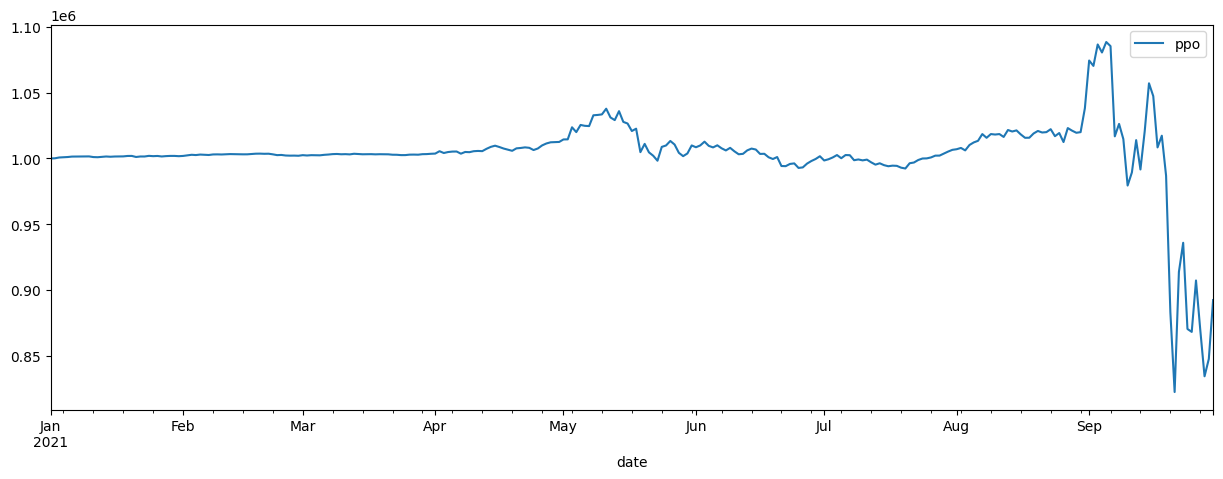

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [37]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();